### Read in all the words and build vocabulary

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

### Build the dataset

`X` are the sequences of the characters\
`Y` are the next characters after the sequence

`tr` training set\
`dev` validation set\
`te` test set\

In [5]:
block_size=3

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one? 
    X, Y = [], [] # input, labels
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append new character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


```torch.tanh```\
Returns a new tensor with the hyperbolic tangent of the elements of input.

```torch.tensor.view```\
Returns a new tensor with the same data as the self tensor but of a different shape.

```F.cross_entropy```\
This criterion computes the cross entropy loss between input logits and target.

In [6]:
# # calibrate the batch norm at the end of training

# with torch.no_grad():
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 #+ b1
#     # measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [7]:
# @torch.no_grad() # disabled gradient tracking
# def split_loss(split):
#     x, y = {
#         "train": (Xtr, Ytr),
#         "val": (Xdev, Ydev),
#         "test": (Xte, Yte),
#     }[split]
#     emb = C[x] # (N, block_size, n_emb)
#     embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_emb)
#     hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
#     #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#     hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
#     h = torch.tanh(hpreact) # (N, n_hidden)
#     logits = h @ W2 + b2 # (N, vocab_size)
#     loss = F.cross_entropy(logits, y)
#     print(split, loss.item())

# split_loss("train")
# split_loss("val")

### Sample from the model

In [8]:
# g = torch.Generator().manual_seed(2147483647)

# for i in range(20):
#     out = []
#     context = [0]*block_size

#     while True:
#         #forward the neural net
#         emb = C[torch.tensor([context])] # (1, block_size, n_embd)
#         h = torch.tanh(emb.view(1, -1) @ W1)
#         logits = h @ W2 + b2
#         probs = F.softmax(logits, dim=1)
#         # sample from the distribution
#         ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#         # shift the context window and track the samples
#         context = context[1:] + [ix]
#         out.append(ix)
#         # if we sample the special "." token, break
#         if ix == 0:
#             break

#     print("".join(itos[i] for i in out)) # decode and print the generated word

# Summary

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [10]:
g = torch.Generator().manual_seed(2147483647)

In [11]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [12]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # mean over batch
            xvar = x.var(0, keepdim=True) # variance over batch
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta # scale and shift
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [14]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [1]:
max_steps = 200000
batch_size=32
lossi=[]
ud = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # embedd characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track stats
    if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimalization

NameError: name 'torch' is not defined

layer 2 (      Tanh): mean -0.00, std +0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std +0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std +0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std +0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std +0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

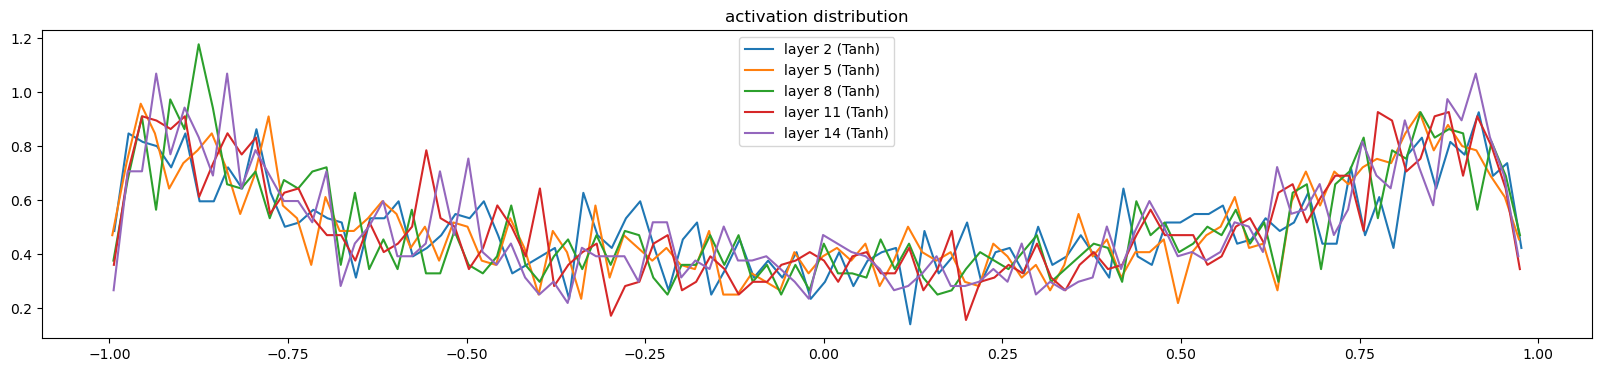

In [16]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %+.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std 3.682945e-03
layer 5 (      Tanh): mean +0.000000, std 3.262603e-03
layer 8 (      Tanh): mean -0.000000, std 2.973724e-03
layer 11 (      Tanh): mean +0.000000, std 2.741104e-03
layer 14 (      Tanh): mean +0.000000, std 2.584291e-03


Text(0.5, 1.0, 'gradient distribution')

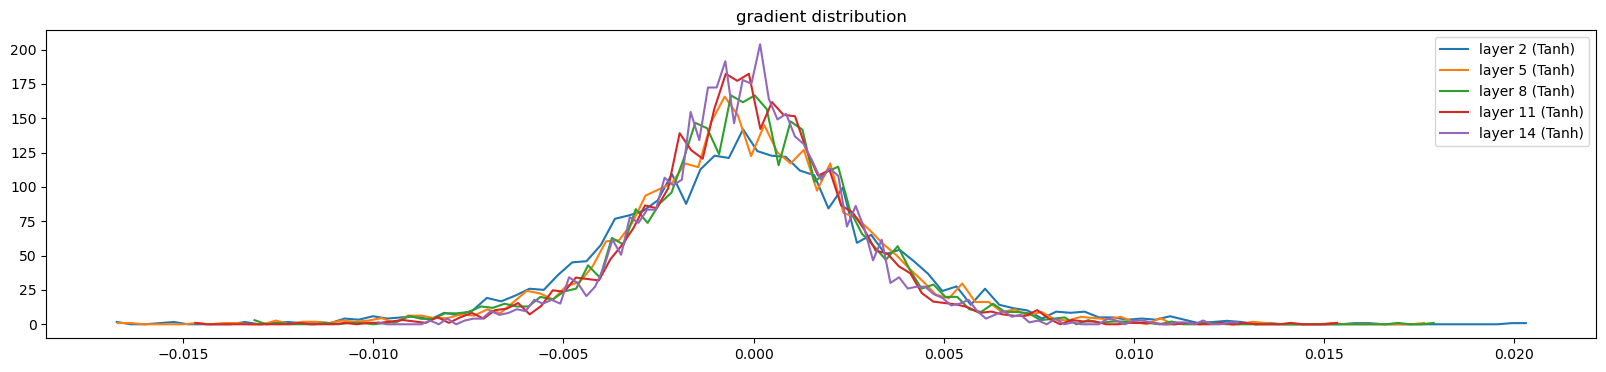

In [17]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 1.019881e-02 | grad:data ratio 1.018842e-02
weight  (30, 100) | mean +0.000092 | std 8.238408e-03 | grad:data ratio 2.635832e-02
weight (100, 100) | mean +0.000031 | std 7.318091e-03 | grad:data ratio 4.377132e-02
weight (100, 100) | mean -0.000019 | std 6.662014e-03 | grad:data ratio 3.949890e-02
weight (100, 100) | mean -0.000019 | std 5.821508e-03 | grad:data ratio 3.468156e-02
weight (100, 100) | mean +0.000053 | std 5.445286e-03 | grad:data ratio 3.243361e-02
weight  (100, 27) | mean -0.000165 | std 1.046842e-02 | grad:data ratio 6.281251e-02


Text(0.5, 1.0, 'weights gradient distribution')

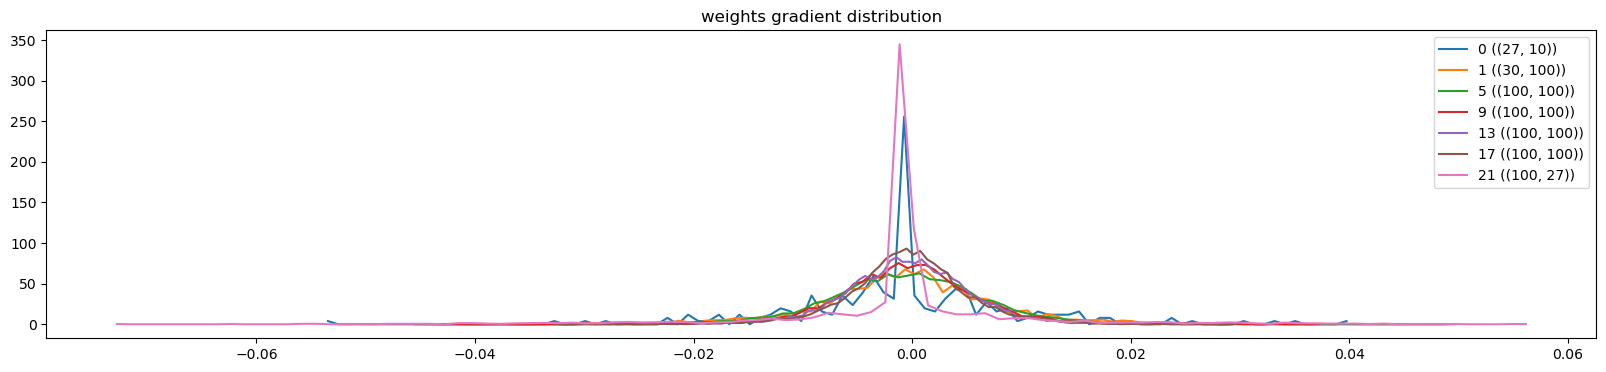

In [18]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title("weights gradient distribution")

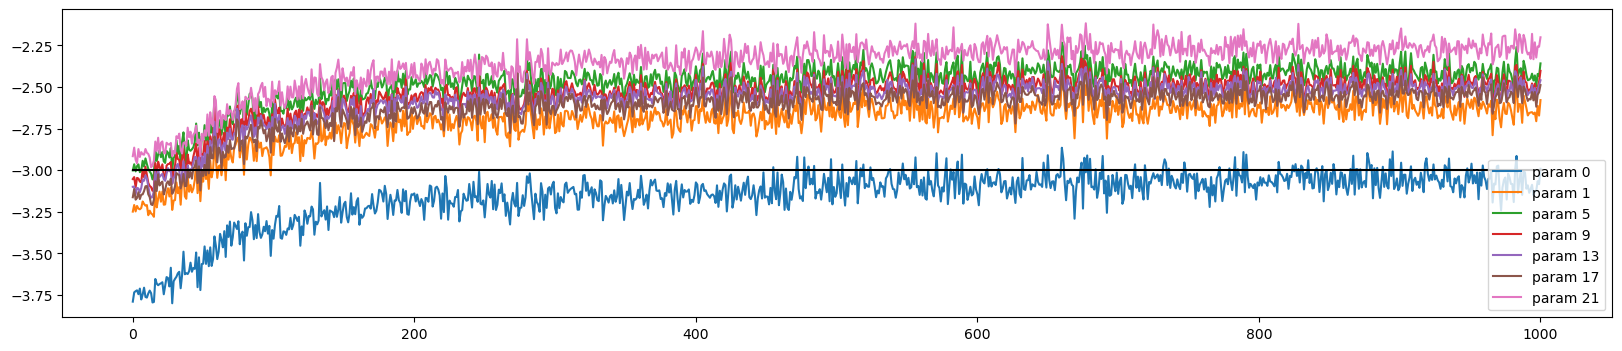

In [19]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)